* utiliser SVM pour la multiclass classification (deux méthodes différentes: one-vs-one ou one-vs-rest)
* utiliser un decision tree (et on peut utiliser tous les bails de boosting, random forest et bagging)
* utiliser un neural network
* utiliser de la cross-validation pour trouver les meilleurs paramètres pour chaque modèle

In [139]:
import numpy as np
import pandas as pd
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn.svm import SVC

# Load data

In [129]:
X = pd.read_csv('./data/hcvdat0.csv', index_col=0).reset_index(drop=True)

# Pre-processing

In this first part, we need to change the ``category`` attribute of the data because we need it to be int. In addition, we change the ``Sex`` attribute from m/f to $0/1$. All the other attributes are already floats, so we keep them as they are.

> m $\rightarrow 0$ and f $\rightarrow 1$

> Blood donor $\rightarrow 0$, Suspect blood donor $\rightarrow 1$, Hepatitis $\rightarrow 2$, Fibrosis $\rightarrow 3$ and Cirrhosis $\rightarrow 4$

## Change the sex and category attributes

In [130]:
class_names = np.unique(X.Category)
X = X.replace({'Sex': {'f':1,'m':0}, 'Category':{'0=Blood Donor':0,'0s=suspect Blood Donor':1, '1=Hepatitis':2, '2=Fibrosis':3, '3=Cirrhosis':4}})

## Remove NaN values

In [131]:
X = X.dropna()

## Split X and y

In [132]:
y = X.Category
X = X.drop('Category', axis=1)

## Split the data in train and test split

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

# Decision tree

## Build the tree

In [134]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

## Compute the accuracy of the tree

In [135]:
y_pred_train = clf.predict(X_train)
accuracy_train = metrics.accuracy_score(y_train, y_pred_train)
print('Accuracy on the train set:', accuracy_train)

y_pred_test = clf.predict(X_test)
accuracy_test = metrics.accuracy_score(y_test, y_pred_test)
print('Accuracy on the test set:', accuracy_test)

Accuracy on the train set: 0.9614512471655329
Accuracy on the test set: 0.9054054054054054


## Visualise the tree

In [136]:
feature_names = X.columns
plot_tree = tree.export_graphviz(clf, out_file=None, filled=True, rounded=True, feature_names=feature_names, class_names=class_names)
graph = graphviz.Source(plot_tree)

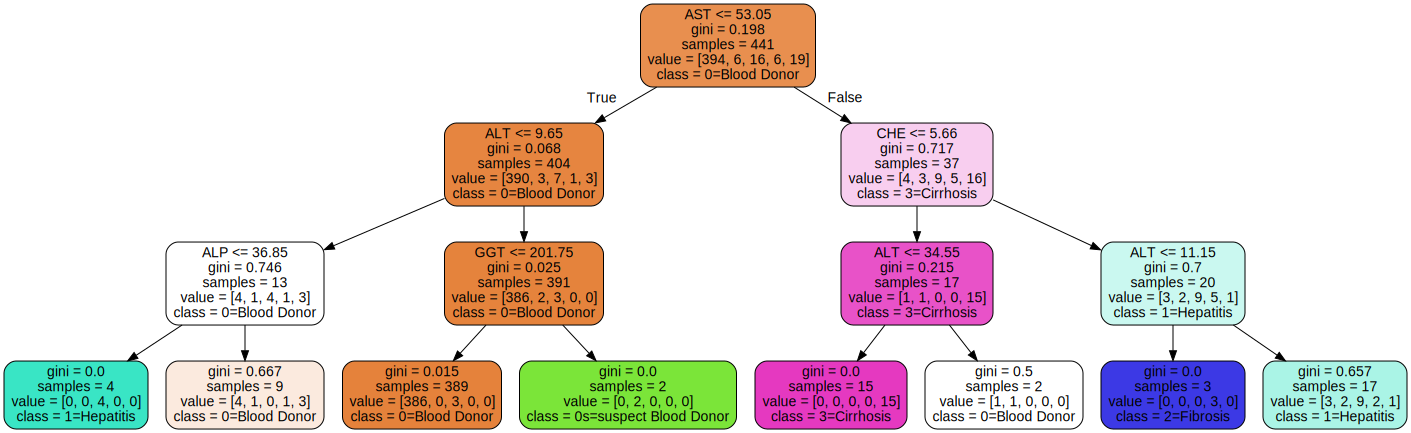

In [137]:
graph

Use ``graph.render('name of the graph', view=True)`` when one wants to save the graph in a pdf file in the same directory as the one containing this notebook.

# SVM

## One versus one classification

In [141]:
clf_ovo = SVC(decision_function_shape='ovo')
clf_ovo.fit(X_train, y_train)

SVC(decision_function_shape='ovo')

In [143]:
clf_ovo.score(X_test, y_test)

0.918918918918919

## One versus rest classification

In [142]:
clf_ovr = SVC(decision_function_shape='ovr')
clf_ovr.fit(X_train, y_train)

SVC()

In [144]:
clf_ovr.score(X_test, y_test)

0.918918918918919

We obtain the same results with the two different methods